In [ ]:
# !pip install ray==0.8.7
# !pip install ray[tune,rllib]
# !pip install symfit
# !pip install dm-tree
# !pip install opencv-python
# !pip install tensorboardX
# !pip install torch torchvision

In [1]:
from tensortrade.oms.instruments import Instrument
import pandas as pd

USD = Instrument("USD", 6, "U.S. Dollar")
CAD = Instrument("CAD", 6, "Canadian Dollar")

df = pd.read_csv('data/USD_CAD_H4_2021-05-07.csv')

df.describe()


,open,high,low,close,volume
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,1.318374,1.319967,1.316767,1.318357,7230.880200
std,0.036112,0.036399,0.035814,0.036127,7389.247272
min,1.215230,1.215970,1.212690,1.213680,1.000000
25%,1.299422,1.300977,1.297720,1.299392,2210.750000
50%,1.318335,1.319745,1.316970,1.318290,4609.000000
75%,1.333775,1.334937,1.332330,1.333712,9545.000000
max,1.462440,1.467060,1.454140,1.462470,59501.000000


<AxesSubplot:>

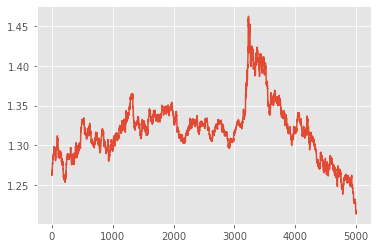

In [2]:
df['close'].plot()

In [3]:
from gym.spaces import Discrete

from tensortrade.env.default.actions import TensorTradeActionScheme

from tensortrade.env.generic import ActionScheme, TradingEnv
from tensortrade.core import Clock
from tensortrade.oms.instruments import ExchangePair
from tensortrade.oms.wallets import Portfolio
from tensortrade.oms.orders import (
    Order,
    proportion_order,
    TradeSide,
    TradeType
)

class BSH(TensorTradeActionScheme):

    registered_name = "bsh"

    def __init__(self, cash: 'Wallet', asset: 'Wallet'):
        super().__init__()
        self.cash = cash
        self.asset = asset

        self.listeners = []
        self.action = 0

    @property
    def action_space(self):
        return Discrete(2)

    def attach(self, listener):
        self.listeners += [listener]
        return self

    def get_orders(self, action: int, portfolio: 'Portfolio'):
        order = None

        if abs(action - self.action) > 0:
            src = self.cash if self.action == 0 else self.asset
            tgt = self.asset if self.action == 0 else self.cash
            order = proportion_order(portfolio, src, tgt, 1.0)
            self.action = action

        for listener in self.listeners:
            listener.on_action(action)

        return [order]

    def reset(self):
        super().reset()
        self.action = 0

In [4]:
from tensortrade.env.default.rewards import TensorTradeRewardScheme
from tensortrade.feed.core import Stream, DataFeed

class PBR(TensorTradeRewardScheme):

    registered_name = "pbr"

    def __init__(self, price: 'Stream'):
        super().__init__()
        self.position = -1

        r = Stream.sensor(price, lambda p: p.value, dtype="float").diff()
        position = Stream.sensor(self, lambda rs: rs.position, dtype="float")

        reward = (r * position * 10000).fillna(0).rename("reward")

        self.feed = DataFeed([reward])
        self.feed.compile()

    def on_action(self, action: int):
        self.position = -1 if action == 0 else 1

    def get_reward(self, portfolio: 'Portfolio'):
        return self.feed.next()["reward"]

    def reset(self):
        self.position = -1
        self.feed.reset()

In [5]:
import matplotlib.pyplot as plt

from tensortrade.env.generic import Renderer

class PositionChangeChart(Renderer):

    def __init__(self, color: str = "orange"):
        self.color = "orange"

    def render(self, env, **kwargs):
        history = pd.DataFrame(env.observer.renderer_history)

        actions = list(history.action)
        p = list(history.price)

        buy = {}
        sell = {}

        for i in range(len(actions) - 1):
            a1 = actions[i]
            a2 = actions[i + 1]

            if a1 != a2:
                if a1 == 0 and a2 == 1:
                    buy[i] = p[i]
                else:
                    sell[i] = p[i]

        buy = pd.Series(buy)
        sell = pd.Series(sell)

        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

        fig.suptitle("Performance")

        axs[0].plot(np.arange(len(p)), p, label="price", color=self.color)
        axs[0].scatter(buy.index, buy.values, marker="^", color="green")
        axs[0].scatter(sell.index, sell.values, marker="^", color="red")
        axs[0].set_title("Trading Chart")
        
#         env.action_scheme.portfolio.performance.plot(ax=axs[1])
        performance = pd.DataFrame.from_dict(env.action_scheme.portfolio.performance, orient='index')
        performance.plot(ax=axs[1])
        axs[1].set_title("Net Worth")

        plt.show()

In [6]:
import ray
import numpy as np
import pandas as pd

from ray import tune
from ray.tune.registry import register_env

import tensortrade.env.default as default

from tensortrade.feed.core import DataFeed, Stream
from tensortrade.oms.exchanges import Exchange
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.wallets import Wallet, Portfolio

def create_env(config):

    p = Stream.source(df['close'] , dtype="float").rename("CAD-USD")

    USD = Instrument("USD", 6, "U.S. Dollar")
    CAD = Instrument("CAD", 6, "Canadian Dollar")

    oanda = Exchange("oanda", service=execute_order)(
                p
            )

    cash = Wallet(oanda, 10000 * CAD * 50) # Leverage of 50 times
    asset = Wallet(oanda, 0 * USD)

    portfolio = Portfolio(CAD, [
        cash,
        asset
    ])
    
    feed = DataFeed([
        p,
        p.rolling(window=10).mean().rename("fast"),
        p.rolling(window=50).mean().rename("medium"),
        p.rolling(window=100).mean().rename("slow"),
        p.log().diff().fillna(0).rename("lr")
    ])

    reward_scheme = PBR(price=p)

    action_scheme = BSH(
        cash=cash,
        asset=asset
    ).attach(reward_scheme)

    renderer_feed = DataFeed([
        # Stream.source(df['date'], dtype="float").rename("date"),
        Stream.source(df['close'], dtype="float").rename("price"),
        Stream.sensor(action_scheme, lambda s: s.action, dtype="float").rename("action")
    ])

    environment = default.create(
        feed=feed,
        portfolio=portfolio,
        action_scheme=action_scheme,
        reward_scheme=reward_scheme,
        renderer_feed=renderer_feed,
        renderer=PositionChangeChart(),
        window_size=config["window_size"],
        max_allowed_loss=0.6
    )
    return environment

register_env("TradingEnv", create_env)

In [7]:
analysis = tune.run(
    "PPO",
    stop={
      "episode_reward_mean": 2000
    },
    config={
        "env": "TradingEnv",
        "env_config": {
            "window_size": 25
        },
        "log_level": "INFO",
        "framework": "torch",
        "ignore_worker_failures": True,
        "num_workers": 1,
        "num_gpus": 0,
        "clip_rewards": True,
        "lr": 8e-6,
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "gamma": 0,
        "observation_filter": "MeanStdFilter",
        "lambda": 0.72,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01
    },
    checkpoint_at_end=True
)

2021-05-13 17:25:32,609	INFO resource_spec.py:223 -- Starting Ray with 1.95 GiB memory available for workers and up to 0.99 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-05-13 17:25:33,248	INFO services.py:1191 -- View the Ray dashboard at localhost:8265


Trial name,status,loc
PPO_TradingEnv_e71df_00000,RUNNING,


(pid=1207) WARNING:tensorflow:From /Users/yuan/Projects/github/ai-trading/env/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=1207) Instructions for updating:
(pid=1207) non-resource variables are not supported in the long term
(pid=1207) 2021-05-13 17:25:45,700	INFO rollout_worker.py:990 -- Built policy map: {'default_policy': <ray.rllib.policy.torch_policy_template.PPOTorchPolicy object at 0x7f99be464400>}
(pid=1207) 2021-05-13 17:25:45,700	INFO rollout_worker.py:991 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7f99be4477f0>}
(pid=1207) 2021-05-13 17:25:45,701	INFO rollout_worker.py:446 -- Built filter map: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=0, mean_mean=0.0, mean_std=0.0), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=1207) 2021-05-13 17:25:45,762	WA

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_e71df_00000,RUNNING,192.168.0.249:1207,1,27.53,4000,-33.1182


Result for PPO_TradingEnv_e71df_00000:
  custom_metrics: {}
  date: 2021-05-13_17-26-30
  done: false
  episode_len_mean: 347.45454545454544
  episode_reward_max: 819.2000000000138
  episode_reward_mean: 77.83636363636437
  episode_reward_min: -650.5000000000047
  episodes_this_iter: 11
  episodes_total: 22
  experiment_id: 310bc373a6734aa9979309e7bff9723c
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.2
        cur_lr: 0.0007000000000000001
        entropy: 0.6063591614365578
        entropy_coeff: 0.01
        kl: 0.03762313025072217
        policy_loss: -0.07415819517336786
        total_loss: 0.41780403163284063
        vf_explained_var: 0.015573594719171524
        vf_loss: 0.9810023829340935
    num_steps_sampled: 8000
    num_steps_trained: 8000
  iterations_since_restore: 2
  node_ip: 192.168.0.249
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_e71df_00000,RUNNING,192.168.0.249:1207,2,44.2579,8000,77.8364


Result for PPO_TradingEnv_e71df_00000:
  custom_metrics: {}
  date: 2021-05-13_17-26-47
  done: false
  episode_len_mean: 364.09375
  episode_reward_max: 1514.8000000000332
  episode_reward_mean: 340.4218750000043
  episode_reward_min: -650.5000000000047
  episodes_this_iter: 10
  episodes_total: 32
  experiment_id: 310bc373a6734aa9979309e7bff9723c
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.30000000000000004
        cur_lr: 0.00030000000000000003
        entropy: 0.5133979581296444
        entropy_coeff: 0.01
        kl: 0.02820783678907901
        policy_loss: -0.06252660002792254
        total_loss: 0.41271625366061926
        vf_explained_var: 0.034424155950546265
        vf_loss: 0.9438289869576693
    num_steps_sampled: 12000
    num_steps_trained: 12000
  iterations_since_restore: 3
  node_ip: 192.168.0.249
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
  

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_e71df_00000,RUNNING,192.168.0.249:1207,3,61.2469,12000,340.422


Result for PPO_TradingEnv_e71df_00000:
  custom_metrics: {}
  date: 2021-05-13_17-27-04
  done: false
  episode_len_mean: 380.0238095238095
  episode_reward_max: 1956.0000000000146
  episode_reward_mean: 610.3309523809598
  episode_reward_min: -650.5000000000047
  episodes_this_iter: 10
  episodes_total: 42
  experiment_id: 310bc373a6734aa9979309e7bff9723c
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.45000000000000007
        cur_lr: 9.800000000000001e-05
        entropy: 0.4386683264747262
        entropy_coeff: 0.01
        kl: 0.014074075152166188
        policy_loss: -0.04971634039247874
        total_loss: 0.4044899772852659
        vf_explained_var: 0.05767074599862099
        vf_loss: 0.9045193325728178
    num_steps_sampled: 16000
    num_steps_trained: 16000
  iterations_since_restore: 4
  node_ip: 192.168.0.249
  num_healthy_workers: 1
  off_policy_estimator: {}
  pe

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_e71df_00000,RUNNING,192.168.0.249:1207,4,78.1749,16000,610.331


Result for PPO_TradingEnv_e71df_00000:
  custom_metrics: {}
  date: 2021-05-13_17-27-20
  done: false
  episode_len_mean: 393.98
  episode_reward_max: 2396.6000000000286
  episode_reward_mean: 796.9920000000104
  episode_reward_min: -650.5000000000047
  episodes_this_iter: 8
  episodes_total: 50
  experiment_id: 310bc373a6734aa9979309e7bff9723c
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.45000000000000007
        cur_lr: 9.400000000000001e-05
        entropy: 0.3706808388233185
        entropy_coeff: 0.01
        kl: 0.009276237105950713
        policy_loss: -0.041351883177412674
        total_loss: 0.40040976452291943
        vf_explained_var: 0.07155521214008331
        vf_loss: 0.8825882934033871
    num_steps_sampled: 20000
    num_steps_trained: 20000
  iterations_since_restore: 5
  node_ip: 192.168.0.249
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cp

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_e71df_00000,RUNNING,192.168.0.249:1207,5,94.8309,20000,796.992


Result for PPO_TradingEnv_e71df_00000:
  custom_metrics: {}
  date: 2021-05-13_17-27-38
  done: false
  episode_len_mean: 409.0
  episode_reward_max: 2654.1000000000554
  episode_reward_mean: 958.6551724138061
  episode_reward_min: -650.5000000000047
  episodes_this_iter: 8
  episodes_total: 58
  experiment_id: 310bc373a6734aa9979309e7bff9723c
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.45000000000000007
        cur_lr: 9.0e-05
        entropy: 0.31569422595202923
        entropy_coeff: 0.01
        kl: 0.007230031245853752
        policy_loss: -0.03151376685127616
        total_loss: 0.393344763899222
        vf_explained_var: 0.10212261974811554
        vf_loss: 0.8495239187031984
    num_steps_sampled: 24000
    num_steps_trained: 24000
  iterations_since_restore: 6
  node_ip: 192.168.0.249
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 3

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_e71df_00000,RUNNING,192.168.0.249:1207,6,112.193,24000,958.655


Result for PPO_TradingEnv_e71df_00000:
  custom_metrics: {}
  date: 2021-05-13_17-27-55
  done: false
  episode_len_mean: 422.73846153846154
  episode_reward_max: 3155.300000000015
  episode_reward_mean: 1114.5953846153993
  episode_reward_min: -650.5000000000047
  episodes_this_iter: 7
  episodes_total: 65
  experiment_id: 310bc373a6734aa9979309e7bff9723c
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.45000000000000007
        cur_lr: 8.6e-05
        entropy: 0.2749084886163473
        entropy_coeff: 0.01
        kl: 0.0054219467274378985
        policy_loss: -0.024566234729718417
        total_loss: 0.3846097094938159
        vf_explained_var: 0.12695585191249847
        vf_loss: 0.8189703114330769
    num_steps_sampled: 28000
    num_steps_trained: 28000
  iterations_since_restore: 7
  node_ip: 192.168.0.249
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_e71df_00000,RUNNING,192.168.0.249:1207,7,129.084,28000,1114.6


Result for PPO_TradingEnv_e71df_00000:
  custom_metrics: {}
  date: 2021-05-13_17-28-11
  done: false
  episode_len_mean: 437.5753424657534
  episode_reward_max: 3155.300000000015
  episode_reward_mean: 1277.224657534263
  episode_reward_min: -650.5000000000047
  episodes_this_iter: 8
  episodes_total: 73
  experiment_id: 310bc373a6734aa9979309e7bff9723c
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.45000000000000007
        cur_lr: 8.2e-05
        entropy: 0.24684584233909845
        entropy_coeff: 0.01
        kl: 0.004235555366904009
        policy_loss: -0.02000173891428858
        total_loss: 0.3803394939750433
        vf_explained_var: 0.1382925808429718
        vf_loss: 0.8018073830753565
    num_steps_sampled: 32000
    num_steps_trained: 32000
  iterations_since_restore: 8
  node_ip: 192.168.0.249
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_e71df_00000,RUNNING,192.168.0.249:1207,8,145.797,32000,1277.22


Result for PPO_TradingEnv_e71df_00000:
  custom_metrics: {}
  date: 2021-05-13_17-28-28
  done: false
  episode_len_mean: 448.1125
  episode_reward_max: 3355.000000000042
  episode_reward_mean: 1411.0212500000184
  episode_reward_min: -650.5000000000047
  episodes_this_iter: 7
  episodes_total: 80
  experiment_id: 310bc373a6734aa9979309e7bff9723c
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.22500000000000003
        cur_lr: 7.8e-05
        entropy: 0.22224453929811716
        entropy_coeff: 0.01
        kl: 0.0035809509208775125
        policy_loss: -0.01854688790626824
        total_loss: 0.36797515908256173
        vf_explained_var: 0.16281357407569885
        vf_loss: 0.775877557694912
    num_steps_sampled: 36000
    num_steps_trained: 36000
  iterations_since_restore: 9
  node_ip: 192.168.0.249
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_perce

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_e71df_00000,RUNNING,192.168.0.249:1207,9,162.737,36000,1411.02


Result for PPO_TradingEnv_e71df_00000:
  custom_metrics: {}
  date: 2021-05-13_17-28-46
  done: false
  episode_len_mean: 455.5287356321839
  episode_reward_max: 3355.000000000042
  episode_reward_mean: 1523.545977011514
  episode_reward_min: -650.5000000000047
  episodes_this_iter: 7
  episodes_total: 87
  experiment_id: 310bc373a6734aa9979309e7bff9723c
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.11250000000000002
        cur_lr: 7.400000000000001e-05
        entropy: 0.1974538518115878
        entropy_coeff: 0.01
        kl: 0.004282707974198274
        policy_loss: -0.0173463094397448
        total_loss: 0.3505290641915053
        vf_explained_var: 0.19599953293800354
        vf_loss: 0.7387362029403448
    num_steps_sampled: 40000
    num_steps_trained: 40000
  iterations_since_restore: 10
  node_ip: 192.168.0.249
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_e71df_00000,RUNNING,192.168.0.249:1207,10,180.146,40000,1523.55


Result for PPO_TradingEnv_e71df_00000:
  custom_metrics: {}
  date: 2021-05-13_17-29-03
  done: false
  episode_len_mean: 463.6914893617021
  episode_reward_max: 3457.9000000000465
  episode_reward_mean: 1638.3553191489566
  episode_reward_min: -650.5000000000047
  episodes_this_iter: 7
  episodes_total: 94
  experiment_id: 310bc373a6734aa9979309e7bff9723c
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.05625000000000001
        cur_lr: 7.000000000000001e-05
        entropy: 0.177648460958153
        entropy_coeff: 0.01
        kl: 0.0033145942943519913
        policy_loss: -0.016778169956523925
        total_loss: 0.3420892162248492
        vf_explained_var: 0.20723536610603333
        vf_loss: 0.7209148593246937
    num_steps_sampled: 44000
    num_steps_trained: 44000
  iterations_since_restore: 11
  node_ip: 192.168.0.249
  num_healthy_workers: 1
  off_policy_estimator: {}
  

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_e71df_00000,RUNNING,192.168.0.249:1207,11,197.565,44000,1638.36


Result for PPO_TradingEnv_e71df_00000:
  custom_metrics: {}
  date: 2021-05-13_17-29-20
  done: false
  episode_len_mean: 472.74
  episode_reward_max: 3652.0000000000296
  episode_reward_mean: 1782.239000000022
  episode_reward_min: -650.5000000000047
  episodes_this_iter: 8
  episodes_total: 102
  experiment_id: 310bc373a6734aa9979309e7bff9723c
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.028125000000000004
        cur_lr: 6.6e-05
        entropy: 0.16025508800521493
        entropy_coeff: 0.01
        kl: 0.0025181515848089475
        policy_loss: -0.01134408637881279
        total_loss: 0.3338896632194519
        vf_explained_var: 0.23966458439826965
        vf_loss: 0.6935309488326311
    num_steps_sampled: 48000
    num_steps_trained: 48000
  iterations_since_restore: 12
  node_ip: 192.168.0.249
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_perc

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_e71df_00000,RUNNING,192.168.0.249:1207,12,214.813,48000,1782.24


Result for PPO_TradingEnv_e71df_00000:
  custom_metrics: {}
  date: 2021-05-13_17-29-37
  done: true
  episode_len_mean: 488.23
  episode_reward_max: 3752.600000000039
  episode_reward_mean: 2015.075000000024
  episode_reward_min: -650.5000000000047
  episodes_this_iter: 7
  episodes_total: 109
  experiment_id: 310bc373a6734aa9979309e7bff9723c
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.014062500000000002
        cur_lr: 6.2e-05
        entropy: 0.15128403319977224
        entropy_coeff: 0.01
        kl: 0.0019242594680690672
        policy_loss: -0.012242879398399964
        total_loss: 0.3095703488215804
        vf_explained_var: 0.27625393867492676
        vf_loss: 0.64659802056849
    num_steps_sampled: 52000
    num_steps_trained: 52000
  iterations_since_restore: 13
  node_ip: 192.168.0.249
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_e71df_00000,RUNNING,192.168.0.249:1207,13,231.548,52000,2015.08


(pid=1207) 2021-05-13 17:29:37,666	WARNING ppo.py:103 -- The magnitude of your environment rewards are more than 202.0x the scale of `vf_clip_param`. This means that it will take more than 202.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_e71df_00000,TERMINATED,,13,231.548,52000,2015.08


In [8]:
import ray.rllib.agents.ppo as ppo

# Get checkpoint
checkpoints = analysis.get_trial_checkpoints_paths(
    trial=analysis.get_best_trial("episode_reward_mean"),
    metric="episode_reward_mean"
)
checkpoint_path = checkpoints[0][0]

# Restore agent
agent = ppo.PPOTrainer(
    env="TradingEnv",
    config={
        "env_config": {
            "window_size": 25
        },
        "framework": "torch",
        "log_level": "DEBUG",
        "ignore_worker_failures": True,
        "num_workers": 1,
        "num_gpus": 0,
        "clip_rewards": True,
        "lr": 8e-6,
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "gamma": 0,
        "observation_filter": "MeanStdFilter",
        "lambda": 0.72,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01
    }
)
agent.restore(checkpoint_path)

2021-05-13 17:45:59,784	DEBUG rollout_worker.py:957 -- Creating policy for default_policy
2021-05-13 17:45:59,788	DEBUG catalog.py:470 -- Created preprocessor <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7fb54b0e0d90>: Box(-inf, inf, (25, 5), float32) -> (25, 5)
2021-05-13 17:45:59,829	INFO rollout_worker.py:990 -- Built policy map: {'default_policy': <ray.rllib.policy.torch_policy_template.PPOTorchPolicy object at 0x7fb54b0bee20>}
2021-05-13 17:45:59,835	INFO rollout_worker.py:991 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7fb54b0e0d90>}
2021-05-13 17:45:59,840	DEBUG rollout_worker.py:412 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
2021-05-13 17:45:59,848	INFO rollout_worker.py:446 -- Built filter map: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=0, mean_mean=0.0, mean_std=0.0), (n=0, mean_mean=0.0, mean_std=0.0))}
2021-05-13 17:45:59,864	DEBUG rollout_w

(pid=1209) WARNING:tensorflow:From /Users/yuan/Projects/github/ai-trading/env/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=1209) Instructions for updating:
(pid=1209) non-resource variables are not supported in the long term
(pid=1209) 2021-05-13 17:46:08,882	DEBUG rollout_worker.py:957 -- Creating policy for default_policy
(pid=1209) 2021-05-13 17:46:08,883	DEBUG catalog.py:470 -- Created preprocessor <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7fae82241820>: Box(-inf, inf, (25, 5), float32) -> (25, 5)
(pid=1209) 2021-05-13 17:46:08,900	DEBUG rollout_worker.py:412 -- Creating policy evaluation worker 1 on CPU (please ignore any CUDA init errors)
(pid=1209) 2021-05-13 17:46:08,903	DEBUG rollout_worker.py:538 -- Created rollout worker with env <ray.rllib.env.base_env._VectorEnvToBaseEnv object at 0x7fae824b5040> (<Trad

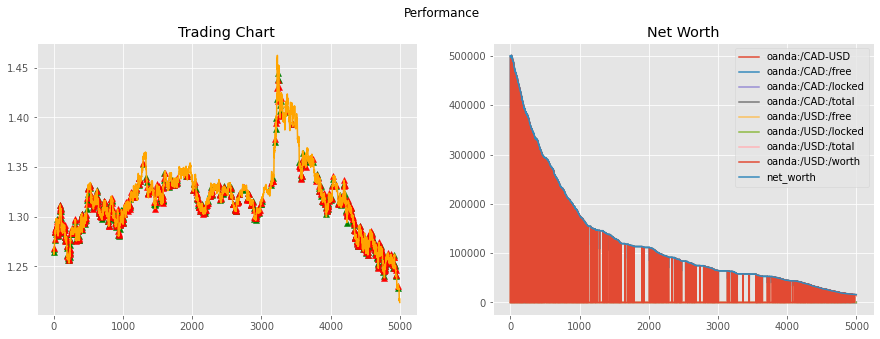

In [9]:
# Instantiate the environment
env = create_env({
    "window_size": 25
})

# Run until episode ends
episode_reward = 0
done = False
obs = env.reset()

for _ in range(len(df.index)):
    action = agent.compute_action(obs)
    obs, reward, done, info = env.step(action)
    episode_reward += reward

env.render()

In [10]:
from pandasgui import show

performance = pd.DataFrame.from_dict(env.action_scheme.portfolio.performance, orient='index')

gui = show(performance)

In [ ]:
gui = show(env.action_scheme.portfolio.ledger.as_frame())